In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [33]:
# author: Ji Liu email: ji.liu@anl.gov

import itertools, numpy
# import circuit_cutter
# import mlrecon_methods as ml
import numpy as np

import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from utils.utils import filter_results, dict_to_list, H_distance, total_counts
from vqe_utils import read_from_file, MeasureCircuit, find_commute_groups, evaluation
import mthree

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='chm185')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-ornl', grou

In [4]:
device = provider.get_backend('ibm_cairo')
device

<IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>

In [5]:
orign_qc = QuantumCircuit.from_qasm_file("qasm/vqe_LiH.qasm")

In [6]:
orign_qc.draw()

┌───┐      ┌───────────────┐   ┌────────────────┐                 »
q_0: ──────┤ X ├──────┤ Ry(-0.003534) ├─■─┤ Ry(-0.0036834) ├─────────────────»
           ├───┤      ├───────────────┤ │ └────────────────┘┌───────────────┐»
q_1: ──────┤ X ├──────┤ Ry(-0.015869) ├─■─────────■─────────┤ Ry(-0.015751) ├»
     ┌─────┴───┴─────┐└───────────────┘           │         └───────────────┘»
q_2: ┤ Ry(0.0038243) ├────────────────────────────■─────────────────■────────»
     ├───────────────┤                                              │        »
q_3: ┤ Ry(-0.019851) ├──────────────────────────────────────────────■────────»
     └───────────────┘                                                       »
«                      
«q_0: ─────────────────
«                      
«q_1: ─────────────────
«     ┌───────────────┐
«q_2: ┤ Ry(0.0036205) ├
«     └┬──────────────┤
«q_3: ─┤ Ry(0.019873) ├
«      └──────────────┘

In [7]:
pauli_list = read_from_file('LiH_hamiltonian.txt')

In [8]:
pauli_commute = find_commute_groups(pauli_list)

In [9]:
pauli_commute

[[('YYYY', (0.030846096963273145+0j)),
  ('IIYY', (0.0007427996394965804+0j)),
  ('YYII', (0.0007427996394965839+0j)),
  ('IIII', (-0.20316606150559144+0j))],
 [('ZZYY', (-0.002737250612332958+0j)),
  ('IZYY', (-0.032395297319862765+0j)),
  ('ZIYY', (0.034389748140479+0j)),
  ('ZZII', (-0.21188984297009175+0j)),
  ('IZII', (0.09275994933497334+0j)),
  ('ZIII', (-0.3652586902160353+0j))],
 [('YYZZ', (-0.002737250612332958+0j)),
  ('YYIZ', (0.032395297319862765+0j)),
  ('YYZI', (-0.034389748140479+0j)),
  ('IIZZ', (-0.21188984297009167+0j)),
  ('IIIZ', (-0.09275994933497325+0j)),
  ('IIZI', (0.3652586902160354+0j))],
 [('XZYY', (-0.007859003265897889+0j)),
  ('XIYY', (0.007859003265897889+0j)),
  ('XZII', (-0.019389408583701813+0j)),
  ('XIII', (0.019389408583701813+0j))],
 [('YYXZ', (0.007859003265897889+0j)),
  ('YYXI', (0.007859003265897889+0j)),
  ('IIXZ', (0.019389408583701813+0j)),
  ('IIXI', (0.019389408583701813+0j))],
 [('YYZX', (-0.0084991584698088+0j)),
  ('YYIX', (0.008499158

In [10]:
len(pauli_commute)

25

In [11]:
pauli_commute

[[('YYYY', (0.030846096963273145+0j)),
  ('IIYY', (0.0007427996394965804+0j)),
  ('YYII', (0.0007427996394965839+0j)),
  ('IIII', (-0.20316606150559144+0j))],
 [('ZZYY', (-0.002737250612332958+0j)),
  ('IZYY', (-0.032395297319862765+0j)),
  ('ZIYY', (0.034389748140479+0j)),
  ('ZZII', (-0.21188984297009175+0j)),
  ('IZII', (0.09275994933497334+0j)),
  ('ZIII', (-0.3652586902160353+0j))],
 [('YYZZ', (-0.002737250612332958+0j)),
  ('YYIZ', (0.032395297319862765+0j)),
  ('YYZI', (-0.034389748140479+0j)),
  ('IIZZ', (-0.21188984297009167+0j)),
  ('IIIZ', (-0.09275994933497325+0j)),
  ('IIZI', (0.3652586902160354+0j))],
 [('XZYY', (-0.007859003265897889+0j)),
  ('XIYY', (0.007859003265897889+0j)),
  ('XZII', (-0.019389408583701813+0j)),
  ('XIII', (0.019389408583701813+0j))],
 [('YYXZ', (0.007859003265897889+0j)),
  ('YYXI', (0.007859003265897889+0j)),
  ('IIXZ', (0.019389408583701813+0j)),
  ('IIXI', (0.019389408583701813+0j))],
 [('YYZX', (-0.0084991584698088+0j)),
  ('YYIX', (0.008499158

In [12]:
#generate individual measurment circuits that changes the basis
meas_qcs = []
for i in range(0, len(pauli_commute)):
    temp_qc = MeasureCircuit(pauli_commute[i], 4, 4)
    meas_qcs.append(temp_qc)

YYYY
YYZZ
ZZYY
YYZX
ZXYY
XZYY
YYXZ
XXYY
YYXX
XZZZ
ZZXZ
XZZX
ZXXZ
XXZZ
ZZXX
XZXZ
ZXZX
XXZX
ZXXX
XZXX
XXXZ
ZZZX
ZXZZ
XXXX
ZZZZ


In [13]:
len(meas_qcs)

25

In [14]:
meas_qcs[0].draw()

┌──────────────┐
q_0: ┤ U(π/2,0,π/2) ├
     ├──────────────┤
q_1: ┤ U(π/2,0,π/2) ├
     ├──────────────┤
q_2: ┤ U(π/2,0,π/2) ├
     ├──────────────┤
q_3: ┤ U(π/2,0,π/2) ├
     └──────────────┘

In [15]:
meas_qcs[-3].draw()

q_0: ──────────────
     ┌────────────┐
q_1: ┤ U(π/2,0,π) ├
     └────────────┘
q_2: ──────────────
                   
q_3: ──────────────

In [16]:
qc_list = []
for qc in meas_qcs:
    temp_qc = orign_qc + qc
    temp_qc.measure_all()
    qc_list.append(temp_qc)

/var/folders/s4/3cvgkkn17hg628pzrzzjnhww0000gn/T/ipykernel_68090/856425490.py:3: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  temp_qc = orign_qc + qc


In [17]:
qc_list[-1].draw()

┌───┐      ┌───────────────┐   ┌────────────────┐»
   q_0: ──────┤ X ├──────┤ Ry(-0.003534) ├─■─┤ Ry(-0.0036834) ├»
              ├───┤      ├───────────────┤ │ └────────────────┘»
   q_1: ──────┤ X ├──────┤ Ry(-0.015869) ├─■─────────■─────────»
        ┌─────┴───┴─────┐└───────────────┘           │         »
   q_2: ┤ Ry(0.0038243) ├────────────────────────────■─────────»
        ├───────────────┤                                      »
   q_3: ┤ Ry(-0.019851) ├──────────────────────────────────────»
        └───────────────┘                                      »
meas_0: ═══════════════════════════════════════════════════════»
                                                               »
meas_1: ═══════════════════════════════════════════════════════»
                                                               »
meas_2: ═══════════════════════════════════════════════════════»
                                                               »
meas_3: ═══════════════════════════════════════════════════════»
                                                               »
«                                           ░ ┌─┐         
«   q_0: ───────────────────────────────────░─┤M├─────────
«        ┌───────────────┐                  ░ └╥┘┌─┐      
«   q_1: ┤ Ry(-0.015751) ├──────────────────░──╫─┤M├──────
«        └───────────────┘┌───────────────┐ ░  ║ └╥┘┌─┐   
«   q_2: ────────■────────┤ Ry(0.0036205) ├─░──╫──╫─┤M├───
«                │        └┬──────────────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ────────■─────────┤ Ry(0.019873) ├─░──╫──╫──╫─┤M├
«                          └──────────────┘ ░  ║  ║  ║ └╥┘
«meas_0: ══════════════════════════════════════╩══╬══╬══╬═
«                                                 ║  ║  ║ 
«meas_1: ═════════════════════════════════════════╩══╬══╬═
«                                                    ║  ║ 
«meas_2: ════════════════════════════════════════════╩══╬═
«                                                       ║ 
«meas_3: ═══════════════════════════════════════════════╩═
«

In [18]:
num_qcs = len(qc_list)
num_qcs

25

In [19]:
simulator = provider.get_backend('ibmq_qasm_simulator')

In [20]:
from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device, gate_error = False, thermal_relaxation= False)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,)), ('measure', (7,)), ('measure', (8,)), ('measure', (9,)), ('measure', (10,)), ('measure', (11,)), ('measure', (12,)), ('measure', (13,)), ('measure', (14,)), ('measure', (15,)), ('measure', (16,)), ('measure', (17,)), ('measure', (18,)), ('measure', (19,)), ('measure', (20,)), ('measure', (21,)), ('measure', (22,)), ('measure', (23,)), ('measure', (24,)), ('measure', (25,)), ('measure', (26,))]


In [21]:
max_shots = simulator.configuration().to_dict()['max_shots']
max_shots

100000

In [22]:
job_sim = execute(qc_list, backend = simulator, noise_model = noise_model, optimization_level =3, shots = max_shots, seed_transpiler = 0)
print(job_sim.job_id())

63770e0c4a1eb581bf1b32db


In [23]:
job_monitor(job_sim)

Job Status: job has successfully run


In [24]:
result = job_sim.result()

In [25]:
result.get_counts()

[{'0000': 6289,
  '0001': 6615,
  '0010': 6206,
  '0011': 6345,
  '0100': 6172,
  '0101': 6520,
  '0110': 5976,
  '0111': 6197,
  '1000': 6288,
  '1001': 6575,
  '1010': 5922,
  '1011': 6328,
  '1100': 6133,
  '1101': 6424,
  '1110': 5841,
  '1111': 6169},
 {'0000': 24429,
  '0001': 25328,
  '0010': 23157,
  '0011': 24457,
  '0100': 240,
  '0101': 223,
  '0110': 239,
  '0111': 233,
  '1000': 438,
  '1001': 462,
  '1010': 375,
  '1011': 407,
  '1100': 5,
  '1101': 4,
  '1110': 1,
  '1111': 2},
 {'0000': 4,
  '0001': 678,
  '0010': 158,
  '0011': 24138,
  '0100': 7,
  '0101': 672,
  '0110': 171,
  '0111': 24218,
  '1000': 3,
  '1001': 712,
  '1010': 175,
  '1011': 24307,
  '1100': 5,
  '1101': 714,
  '1110': 169,
  '1111': 23869},
 {'0000': 12188,
  '0001': 12972,
  '0010': 11955,
  '0011': 12645,
  '0100': 120,
  '0101': 101,
  '0110': 101,
  '0111': 115,
  '1000': 12412,
  '1001': 12729,
  '1010': 11869,
  '1011': 12329,
  '1100': 127,
  '1101': 119,
  '1110': 111,
  '1111': 107},
 {'0

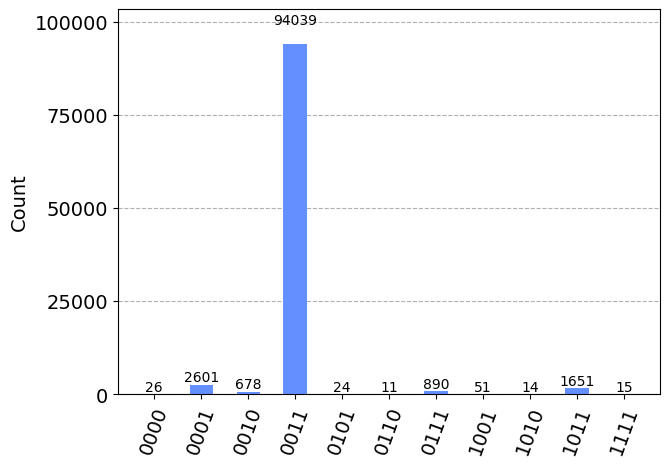

In [26]:
plot_histogram(result.get_counts()[-1])

In [27]:
len(result.get_counts())

25

In [28]:
len(pauli_commute)

25

In [29]:
evaluation(result.get_counts()[-1], shots = max_shots, Pauli = 'zzzz')

0.8836

In [30]:
final_expect_val = 0
for i in range(0, len(pauli_commute)):
    group = pauli_commute[i]
    for Pauli_tuple in group:
        coeff = Pauli_tuple[1]
        final_expect_val += coeff * evaluation(result.get_counts()[i], shots = max_shots, Pauli = Pauli_tuple[0])  

In [31]:
final_expect_val

(-1.029099989747523+0j)

In [34]:
mit = mthree.M3Mitigation(device)

In [35]:
mit.cals_from_system(range(4))